In [1]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from torchinfo import summary
from IPython.display import clear_output
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from funcs import get_cifar10_mu_std_img, normalize
from resnet import *

In [2]:
device = torch.device("cuda")

In [3]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
BATCH_SIZE = 100
loader_train = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
loader_test = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
from resnet import resnet50

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()

    return hook

In [7]:
model.layer4.register_forward_hook(get_features('last_conv'))
model.avgpool.register_forward_hook(get_features('last_fc'))

In [8]:
num_train_samples = len(training_data)

last_conv_feats, last_fc_feats = [], []
x_train, y_train = [], []

# placeholder for batch features
features = {}

mu_img, std_img = get_cifar10_mu_std_img()
# loop through batches
for idx, batch in enumerate(loader_train):
    x = batch[0]
    y = batch[1]
    x_train.append(x)
    y_train.append(y)

    #x = normalize(torch.clone(x), mu_img, std_img)

    x = x.to(device)
    # forward pass [with feature extraction]
    preds = model(x)

    # add feats and preds to lists
    last_conv_feats.append(features['last_conv'].cpu().numpy())
    last_fc_feats.append(features['last_fc'].cpu().numpy())

    print('Finished', idx, 'batches...')
    clear_output(wait=True)

Finished 499 batches...


In [9]:
raw_pixel_feats = np.array(x_train).reshape(num_train_samples, -1)
labels = np.array(y_train).reshape(num_train_samples, )
conv_feats = np.array(last_conv_feats).reshape(num_train_samples, -1)
fc_feats = np.array(last_fc_feats).reshape(num_train_samples, -1)


In [10]:
#from funcs import kmeans_cost

def kmeans_cost(feat, kmeans):
    pred = kmeans.predict(feat)
    centers = kmeans.cluster_centers_[pred]
    distances = [np.linalg.norm(feat[i]-centers[i]) for i in range(len(feat))]
    cost = np.sum(distances)
    return cost

raw_costs, conv_costs, fc_costs  = [], [], []
raw_clusters, conv_clusters, fc_clusters = [], [], []
for i in np.arange(1,21):
    raw_kmeans = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000, random_state=0).fit(raw_pixel_feats)
    conv_kmeans = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000, random_state=0).fit(conv_feats)
    fc_kmeans = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000, random_state=0).fit(fc_feats)

    raw_costs.append(kmeans_cost(raw_pixel_feats, raw_kmeans))
    conv_costs.append(kmeans_cost(conv_feats, conv_kmeans))
    fc_costs.append(kmeans_cost(fc_feats, fc_kmeans))

    raw_clusters.append(raw_kmeans)
    conv_clusters.append(conv_kmeans)
    fc_clusters.append(fc_kmeans)

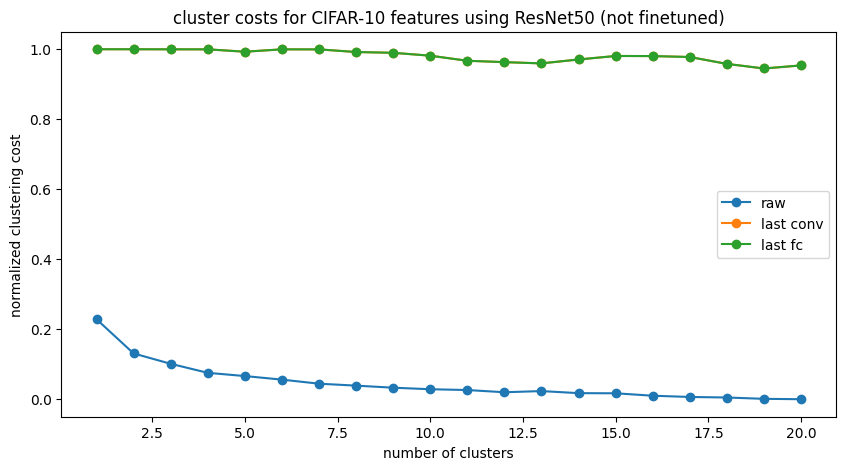

In [11]:
max_cost, min_cost = max(np.max(raw_costs), np.max(conv_costs), np.max(fc_costs)), min(np.min(raw_costs), np.min(conv_costs), np.min(fc_costs))
norm_raw_costs = (np.array(raw_costs) - min_cost)/(max_cost - min_cost)
norm_conv_costs = (np.array(conv_costs) - min_cost)/(max_cost - min_cost)
norm_fc_costs = (np.array(fc_costs) - min_cost)/(max_cost - min_cost)

k_vals = np.arange(1,21)
fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax.plot(k_vals, norm_raw_costs, label='raw', marker='o')
ax.plot(k_vals, norm_conv_costs, label='last conv', marker='o')
ax.plot(k_vals, norm_fc_costs, label='last fc', marker='o')
ax.set_xlabel("number of clusters")
ax.set_ylabel("normalized clustering cost")
ax.set_title("cluster costs for CIFAR-10 features using ResNet50 (not finetuned)")
ax.legend()

In [12]:
def compute_m(i, data, labels):
    diff = data - data[i]
    dist = np.sqrt(np.sum(diff**2,axis=-1))
    indices = np.arange(data.shape[0])
    index_dist_tuples = list(zip(indices, dist))
    sorted_dists = sorted(index_dist_tuples, key=lambda tup: tup[1])

    new_list = []
    x_label = labels[i]
    labels_in_ball = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
    for s,d in sorted_dists:
        labels_in_ball[labels[s]] += 1
        majority_label = max(labels_in_ball, key=labels_in_ball.get)
        if majority_label != x_label:
            break
        new_list.append((s,d))
    
    m = len(new_list) / data.shape[0]
    return m

def compute_m_vals(data, labels, subset_size):
    m_vals = []
    for i in np.arange(data.shape[0]):
        m = compute_m(i, data, labels)
        m_vals.append(m)

        if i%100 == 0:
            print('Finished', i, 'iterations...')
            clear_output(wait=True)

        if i >= subset_size:
            break
        
    return m_vals  

[4e-05, 0.0003, 2e-05, 0.82394, 4e-05, 0.00028, 2e-05, 2e-05, 6e-05, 8e-05, 2e-05, 2e-05, 0.87988, 4e-05, 0.83066, 2e-05, 0.00028, 2e-05, 2e-05, 4e-05, 2e-05, 0.00042, 2e-05, 0.98994, 0.0001, 0.03062, 0.00016, 6e-05, 8e-05, 6e-05, 0.83636, 0.0003, 6e-05, 2e-05, 0.00026, 0.00024, 2e-05, 8e-05, 2e-05, 4e-05, 2e-05, 0.0009, 2e-05, 2e-05, 2e-05, 0.61936, 4e-05, 6e-05, 2e-05, 0.0002, 6e-05, 4e-05, 0.00016, 4e-05, 0.01788, 0.83086, 0.00328, 8e-05, 2e-05, 0.92864, 4e-05, 2e-05, 2e-05, 0.00288, 0.51974, 0.00032, 2e-05, 4e-05, 0.0014, 0.0002, 0.0006, 0.00806, 0.01404, 0.87932, 2e-05, 0.0001, 0.00012, 0.00026, 2e-05, 0.00016, 8e-05, 0.00036, 0.0001, 0.0003, 2e-05, 0.8233, 0.21556, 4e-05, 2e-05, 0.00042, 2e-05, 4e-05, 0.00012, 2e-05, 0.00012, 0.00012, 0.00024, 0.97566, 0.00012, 0.99902, 0.91384, 0.0086, 2e-05, 6e-05, 0.53524, 8e-05, 2e-05, 2e-05, 0.00018, 2e-05, 0.00186, 8e-05, 0.00012, 0.01274, 0.00012, 2e-05, 0.87936, 0.00016, 6e-05, 2e-05, 0.0001, 4e-05, 2e-05, 4e-05, 0.00052, 8e-05, 6e-05, 0.

(array([860.,  18.,   5.,   4.,   6.,   3.,   7.,   6.,   3.,   5.,   6.,
          7.,   2.,   1.,   3.,   4.,  14.,  23.,   9.,  15.]),
 array([2.0000e-05, 4.9970e-02, 9.9920e-02, 1.4987e-01, 1.9982e-01,
        2.4977e-01, 2.9972e-01, 3.4967e-01, 3.9962e-01, 4.4957e-01,
        4.9952e-01, 5.4947e-01, 5.9942e-01, 6.4937e-01, 6.9932e-01,
        7.4927e-01, 7.9922e-01, 8.4917e-01, 8.9912e-01, 9.4907e-01,
        9.9902e-01]),
 <BarContainer object of 20 artists>)

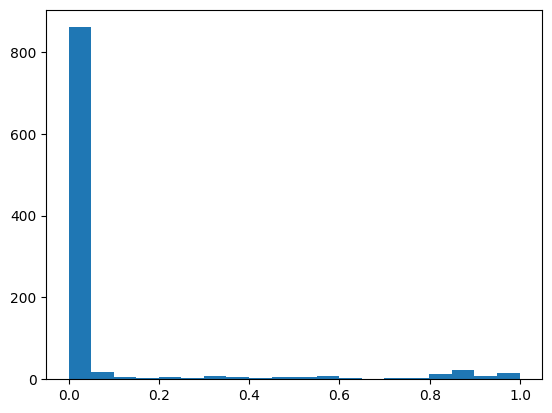

In [13]:
raw_m_vals = compute_m_vals(raw_pixel_feats, labels, 1000)
print(raw_m_vals)
plt.hist(raw_m_vals, bins=20)

[2e-05, 6e-05, 2e-05, 0.00458, 2e-05, 2e-05, 2e-05, 2e-05, 8e-05, 0.00088, 2e-05, 0.0001, 0.00146, 0.0012, 0.0001, 8e-05, 4e-05, 4e-05, 6e-05, 0.00048, 6e-05, 0.0331, 2e-05, 6e-05, 6e-05, 4e-05, 0.00012, 0.0004, 0.0001, 6e-05, 0.00024, 0.00012, 8e-05, 0.00068, 2e-05, 6e-05, 2e-05, 0.00018, 2e-05, 0.00026, 2e-05, 6e-05, 4e-05, 0.03894, 2e-05, 0.00146, 8e-05, 6e-05, 0.0047, 0.0027, 2e-05, 0.00012, 4e-05, 2e-05, 0.00012, 0.97908, 0.00012, 6e-05, 0.00038, 0.0126, 4e-05, 2e-05, 6e-05, 0.96, 6e-05, 0.00098, 2e-05, 0.95826, 0.0177, 2e-05, 0.00014, 4e-05, 2e-05, 0.00036, 4e-05, 0.0021, 2e-05, 0.0001, 8e-05, 0.00016, 4e-05, 2e-05, 8e-05, 0.00022, 2e-05, 0.95894, 2e-05, 6e-05, 2e-05, 8e-05, 2e-05, 2e-05, 0.0004, 2e-05, 6e-05, 6e-05, 4e-05, 0.0014, 0.00064, 4e-05, 2e-05, 0.00026, 0.06394, 0.00076, 2e-05, 0.9515, 8e-05, 2e-05, 8e-05, 2e-05, 2e-05, 0.00042, 0.00208, 2e-05, 2e-05, 2e-05, 0.01396, 2e-05, 0.00016, 4e-05, 2e-05, 0.00158, 2e-05, 8e-05, 2e-05, 0.96316, 4e-05, 0.0001, 0.00012, 2e-05, 6e-0

(array([951.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  45.]),
 array([2.00000e-05, 4.89730e-02, 9.79260e-02, 1.46879e-01, 1.95832e-01,
        2.44785e-01, 2.93738e-01, 3.42691e-01, 3.91644e-01, 4.40597e-01,
        4.89550e-01, 5.38503e-01, 5.87456e-01, 6.36409e-01, 6.85362e-01,
        7.34315e-01, 7.83268e-01, 8.32221e-01, 8.81174e-01, 9.30127e-01,
        9.79080e-01]),
 <BarContainer object of 20 artists>)

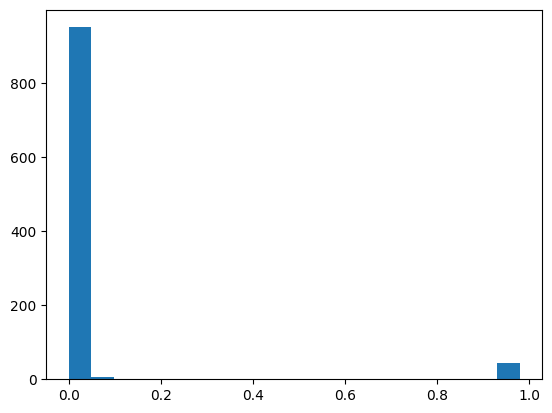

In [14]:
conv_m_vals = compute_m_vals(conv_feats, labels, 1000)
print(conv_m_vals)
plt.hist(conv_m_vals, bins=20)

[2e-05, 6e-05, 2e-05, 0.00458, 2e-05, 2e-05, 2e-05, 2e-05, 8e-05, 0.00088, 2e-05, 0.0001, 0.00146, 0.0012, 0.0001, 8e-05, 4e-05, 4e-05, 6e-05, 0.00048, 6e-05, 0.0331, 2e-05, 6e-05, 6e-05, 4e-05, 0.00012, 0.0004, 0.0001, 6e-05, 0.00024, 0.00012, 8e-05, 0.00068, 2e-05, 6e-05, 2e-05, 0.00018, 2e-05, 0.00026, 2e-05, 6e-05, 4e-05, 0.03894, 2e-05, 0.00146, 8e-05, 6e-05, 0.0047, 0.0027, 2e-05, 0.00012, 4e-05, 2e-05, 0.00012, 0.97908, 0.00012, 6e-05, 0.00038, 0.0126, 4e-05, 2e-05, 6e-05, 0.96, 6e-05, 0.00098, 2e-05, 0.95826, 0.0177, 2e-05, 0.00014, 4e-05, 2e-05, 0.00036, 4e-05, 0.0021, 2e-05, 0.0001, 8e-05, 0.00016, 4e-05, 2e-05, 8e-05, 0.00022, 2e-05, 0.95894, 2e-05, 6e-05, 2e-05, 8e-05, 2e-05, 2e-05, 0.0004, 2e-05, 6e-05, 6e-05, 4e-05, 0.0014, 0.00064, 4e-05, 2e-05, 0.00026, 0.06394, 0.00076, 2e-05, 0.9515, 8e-05, 2e-05, 8e-05, 2e-05, 2e-05, 0.00042, 0.00208, 2e-05, 2e-05, 2e-05, 0.01396, 2e-05, 0.00016, 4e-05, 2e-05, 0.00158, 2e-05, 8e-05, 2e-05, 0.96316, 4e-05, 0.0001, 0.00012, 2e-05, 6e-0

(array([951.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  45.]),
 array([2.00000e-05, 4.89730e-02, 9.79260e-02, 1.46879e-01, 1.95832e-01,
        2.44785e-01, 2.93738e-01, 3.42691e-01, 3.91644e-01, 4.40597e-01,
        4.89550e-01, 5.38503e-01, 5.87456e-01, 6.36409e-01, 6.85362e-01,
        7.34315e-01, 7.83268e-01, 8.32221e-01, 8.81174e-01, 9.30127e-01,
        9.79080e-01]),
 <BarContainer object of 20 artists>)

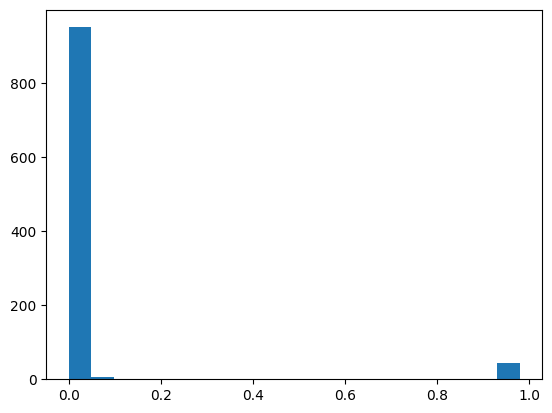

In [15]:
fc_m_vals = compute_m_vals(fc_feats, labels, 1000)
print(fc_m_vals)
plt.hist(fc_m_vals, bins=20)

Text(0.5, 1.0, 'Margins for Last FC Features from CIFAR-10 using ResNet50 (not finetuned)')

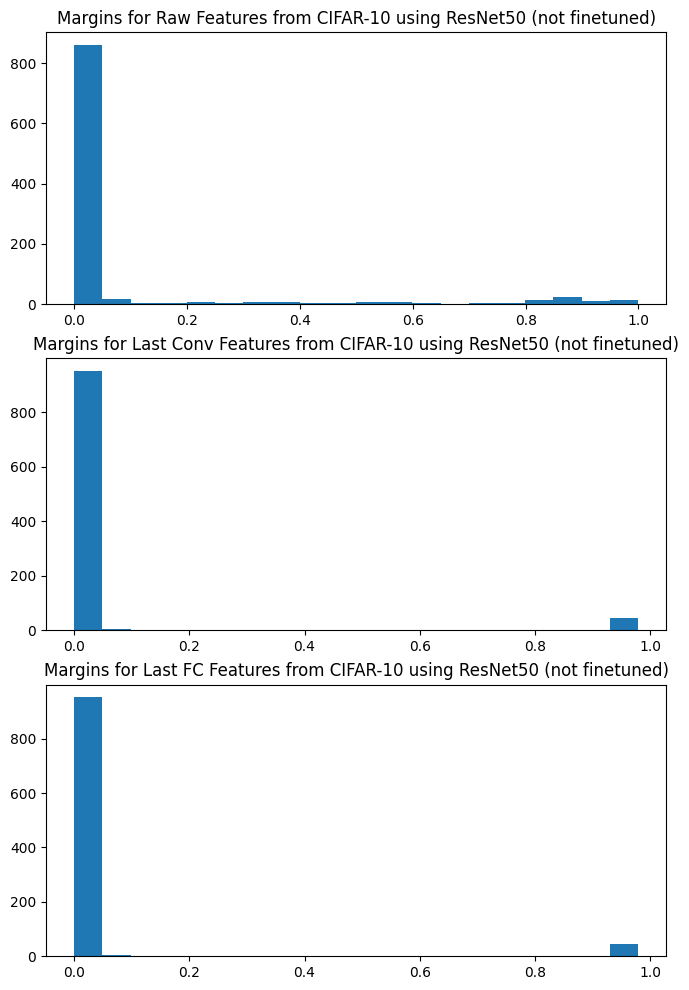

In [31]:
fig, ax = plt.subplots(3,1, figsize=(8, 12))
ax[0].hist(raw_m_vals, bins=20)
ax[1].hist(conv_m_vals, bins=20)
ax[2].hist(fc_m_vals, bins=20)
ax[0].set_title("Margins for Raw Features from CIFAR-10 using ResNet50 (not finetuned)")
ax[1].set_title("Margins for Last Conv Features from CIFAR-10 using ResNet50 (not finetuned)")
ax[2].set_title("Margins for Last FC Features from CIFAR-10 using ResNet50 (not finetuned)")